[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar09/ml_kidney_stones/blob/main/patches_resnet.ipynb)



### Steps to perform before running this notebook:
- You must have access to shared folder: **Proyecto_CalculosRenales**.
- You need to add a shorcut for this folder (right click -> Add shortcut to drive).

In [ ]:
import os
import numpy as np
import torch
from torchvision import transforms, utils, datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

!pip install pytorch-lightning==1.0.2 --quiet
! pip install pytorch-lightning --quiet
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

#optional
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initialization

Some classes are used in different notebooks. To keep all the code in a single place, the below code will clone the "ml_kindey_stones" repository and import the classes we need for the current notebook.

In [ ]:
!rm -r ml_kidney_stones
GIT_PATH = "https://b5d855b5170d85046de2b73eb566937c894aec67@github.com/oscar09/ml_kidney_stones.git"
!cd /content/ && git clone "{GIT_PATH}"

Cloning into 'ml_kidney_stones'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 155 (delta 85), reused 48 (delta 22), pack-reused 0
Receiving objects: 100% (155/155), 4.47 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
import ml_kidney_stones.helpers.KidneyImagesLoader as kl
import ml_kidney_stones.helpers.PlotHelper as kplt
import ml_kidney_stones.helpers.transferLearningBaseModel as tlm

Initializes the variables that are used in this notebook. The mean and std used for normalization are the values given by ImageNET. If we need to run tests with different values, we just need to update the below code and run the whole notebook or the cell we are interested in.

The image size is also set to 256x256, which is the dimension used by ResNet. The dataset will be resized to this dimension. Transformations are also defined in here and the following transformations are being applied:

Training set:
- RandomHorizontalFlip(p=0.5),
- RandomVerticalFlip(p=0.5),
- Pad(50, fill=0, padding_mode="symmetric"),
- RandomPerspective(distortion_scale=0.4, p=0.5),
- RandomAffine(degrees=(-90, 90), translate=(0, 0.2), scale=[0.5, 1]),
- RandomRotation(degrees=(-180, 180))

This transformations are applied randomly and only 1 on every iteration. For the test dataset no transformations are being applied.

Early stopping (with a patience of 30) is also being used in every test. But at least MIN_EXEC_EPOCHS epochs should be executed before early stopping is applied.

In [ ]:
LOGS_PATH = "tb_logs/resnet/" #"/content/drive/My Drive/colab_logs/"
TOTAL_GPUS = 0
if torch.cuda.is_available():
  TOTAL_GPUS = 1


#imagenet values
#@TODO - I need to calculate the  mean and std for our images.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
#mean = np.array([0.5, 0.5, 0.5])
#std = np.array([0.5, 0.5, 0.5])

IMG_SIZE = 256 # Expected size for AlexNet.

# WITH augmentation
image_transforms = {
    "train": transforms.Compose([
      transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Pad(50, fill=0, padding_mode="symmetric"),
        transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
        transforms.RandomAffine(degrees=(-90, 90), translate=(0, 0.2), scale=[0.5, 1]),
        #transforms.ColorJitter(brightness=0.35, contrast=0.4, saturation=0.5, hue=0),
        transforms.RandomRotation(degrees=(-180, 180)),                     
      ]),
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)                           
    ]),
    "test": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)   
    ])
}

# WITHOUT augmentation
image_transforms_no_aug = {
    "train": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)                           
    ]),
    "test": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)   
    ])
}

# Early stopping
stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=30,
    verbose=True,
    mode='min'
)

# min epochs to run
MIN_EXEC_EPOCHS = 100
# max epochs to run
MAX_EXEC_EPOCHS = 100

## Aditional code to store the tensorobard logs in google drive.
def synch_logs(drive_path):
  !rsync -av --progress "$LOGS_PATH" "$drive_path"

def clear_logs():
  !rm -r "$LOGS_PATH"

def copy_logs(drive_path):
  !rsync -av --progress "$drive_path" "$LOGS_PATH"

# RestNet34.

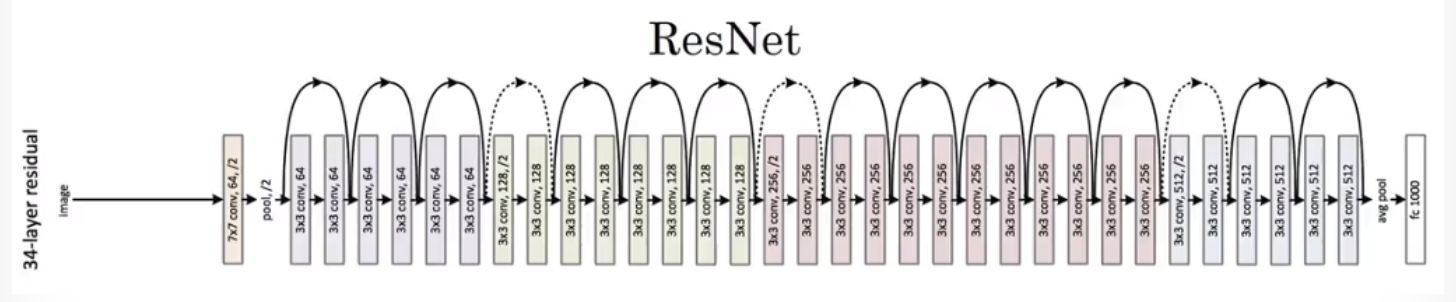

In [ ]:
class Resnet34Model(tlm.BaseModel):
  def __init__(self, hparams={}, num_classes=6, batch_size=64, pretrained=False):
    if "lr" not in hparams:
        hparams["lr"] = 0.001
    #LOG INFO
    hparams["num_classes"] = num_classes
    hparams["batch_size"] = batch_size
    hparams["is_pretrained"] = pretrained
    super(Resnet34Model, self).__init__(hparams)
    self.resnet = models.resnet34(pretrained=pretrained)
    self.resnet.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, num_classes))
    self.batch_size = batch_size
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.resnet(x)

# Testing the model: *Images with patches and all classes*

The below cells test resNet34 model with our patches dataset and classifies the images in 6 classes (weddellite_surfaces, weddellite_sections, acide_urique_surface, acide_urique_section, whewellite_surface, whewellite_section).

The below hyper parameters are used:
- **Percentage of the training set that is used for validation:** 20%.
- **Batch size for the training set:** 32,
- **Learning rate:** .001.
- **Early stopping**.
- Augmentation in the training set (described previously).

For every test logs are being generated and can be rendered at the end of this notebook under the section "Tensorboard logs".


In [ ]:
clear_logs()
dl_six_classes = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_six_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms["train"],
                          test_transformations=image_transforms["test"])

model_six = Resnet34Model(hparams={"lr": 0.0006}, num_classes=6, pretrained=True)

logger_patched_six = TensorBoardLogger(LOGS_PATH, name='resnet34_patched_six', version=".")
trainer_patched_six = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MIN_EXEC_EPOCHS,
                     min_epochs=MAX_EXEC_EPOCHS,
                     logger=logger_patched_six,
                     callbacks=[stopping],
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find=True
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#find learning rate
#dl_six_classes.setup()
#trainer_patched_six.tune(model_six, dl_six_classes.train_dataloader(), dl_six_classes.val_dataloader())

### Training Phase

Training phase is executed and the accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_six.fit(model_six, dl_six_classes)


  | Name    | Type             | Params
---------------------------------------------
0 | resnet  | ResNet           | 21 M  
1 | loss_fn | CrossEntropyLoss | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [ ]:
model_six.set_class_indices(dl_six_classes.get_class_indices())
acc_history = model_six.get_accuracy_history()
loss_history = model_six.get_loss_history()

/content/ml_kidney_stones/helpers/PlotHelper.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


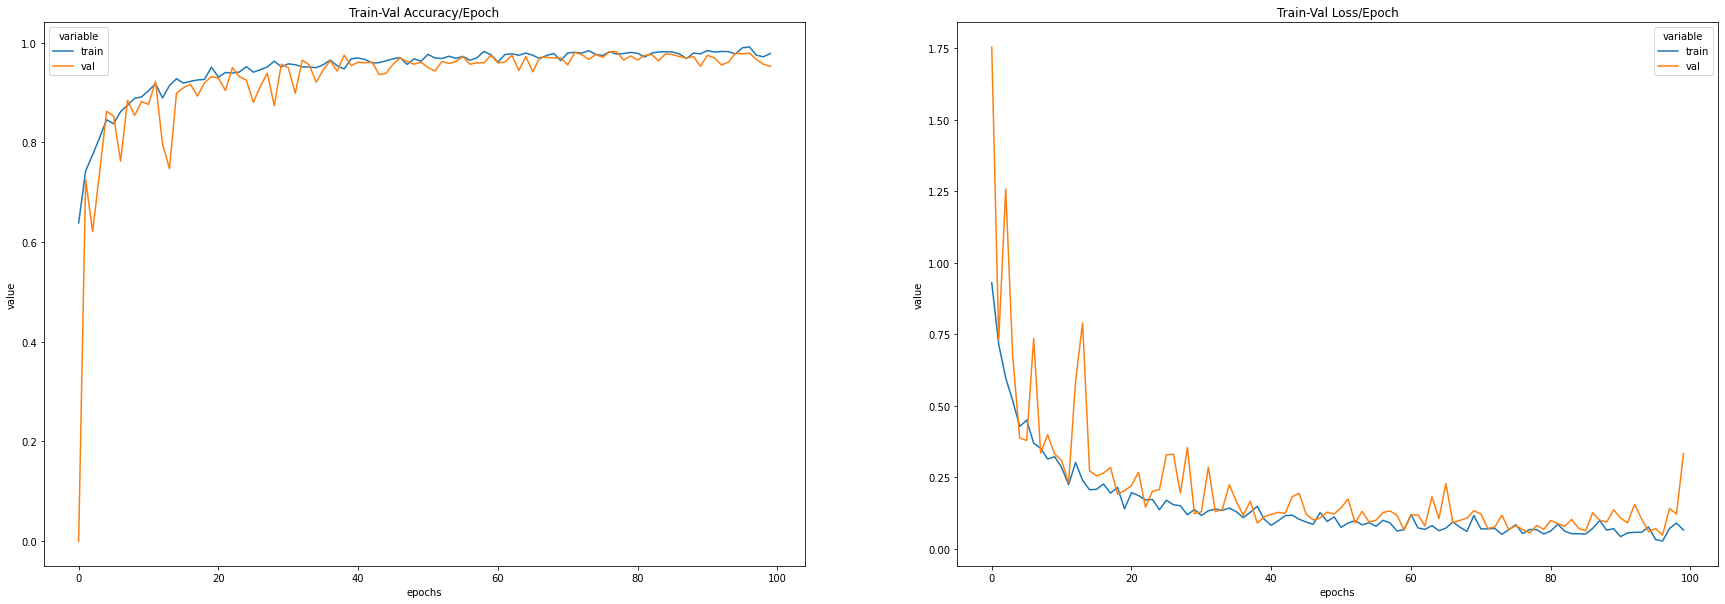

In [ ]:
plotter = kplt.PlotHelper()
plotter.show_training_results(acc_history, loss_history, logger=logger_patched_six)

### Test Phase

Displays the classification report based on the trained model.

                             precision    recall  f1-score   support

  a-iib_weddellite_surfaces       1.00      0.95      0.97       150
  b-iib_weddellite_sections       1.00      1.00      1.00       150
c-iiib_acide_urique_surface       0.95      0.99      0.97       150
d-iiib_acide_urique_section       0.98      1.00      0.99       150
    e-ia-whewellite_surface       1.00      1.00      1.00       150
    f-ia-whewellite_section       1.00      1.00      1.00       150

                   accuracy                           0.99       900
                  macro avg       0.99      0.99      0.99       900
               weighted avg       0.99      0.99      0.99       900

--------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


1

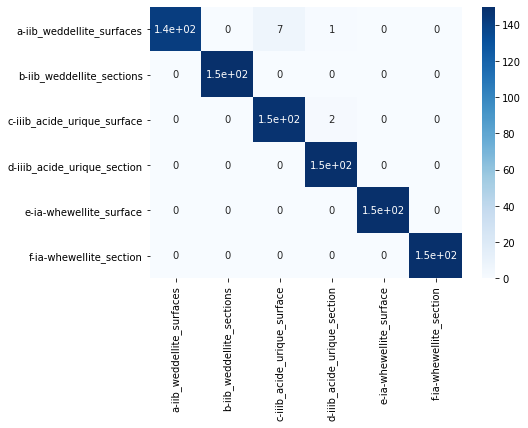

In [ ]:
trainer_patched_six.test(model=model_six, datamodule=dl_six_classes)

# Testing the model: *Images with patches and 3 classes*

The below cells test resNet34 model with our patches dataset and classifies the images in 3 classes (weddellite, acide_urique, whewellite). "Surface" and "Section" datasets are merged into a single class.

The below hyper parameters are used:
- **Percentage of the training set that is used for validation:** 20%.
- **Batch size for the training set:** 32,
- **Learning rate:** .001.
- **Early stopping**.
- Augmentation in the training set (described previously).

For every test logs are being generated and can be rendered at the end of this notebook under the section "Tensorboard logs".


In [ ]:
dl_three_classes = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_three_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms["train"],
                          test_transformations=image_transforms["test"])

model_three = Resnet34Model(hparams={"lr": 0.0006}, num_classes=3, pretrained=True)

logger_patched_three = TensorBoardLogger(LOGS_PATH, name='resnet34_patched_three', version=".")
trainer_patched_three = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MIN_EXEC_EPOCHS,
                     min_epochs=MAX_EXEC_EPOCHS,
                     logger=logger_patched_three,
                     callbacks=[stopping],
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find=True
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training Phase

Training phase is executed and the accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_three.fit(model_three, dl_three_classes)


  | Name    | Type             | Params
---------------------------------------------
0 | resnet  | ResNet           | 21 M  
1 | loss_fn | CrossEntropyLoss | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


1

In [ ]:
model_three.set_class_indices(dl_three_classes.get_class_indices())
acc_history = model_three.get_accuracy_history()
loss_history = model_three.get_loss_history()

/content/ml_kidney_stones/helpers/PlotHelper.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


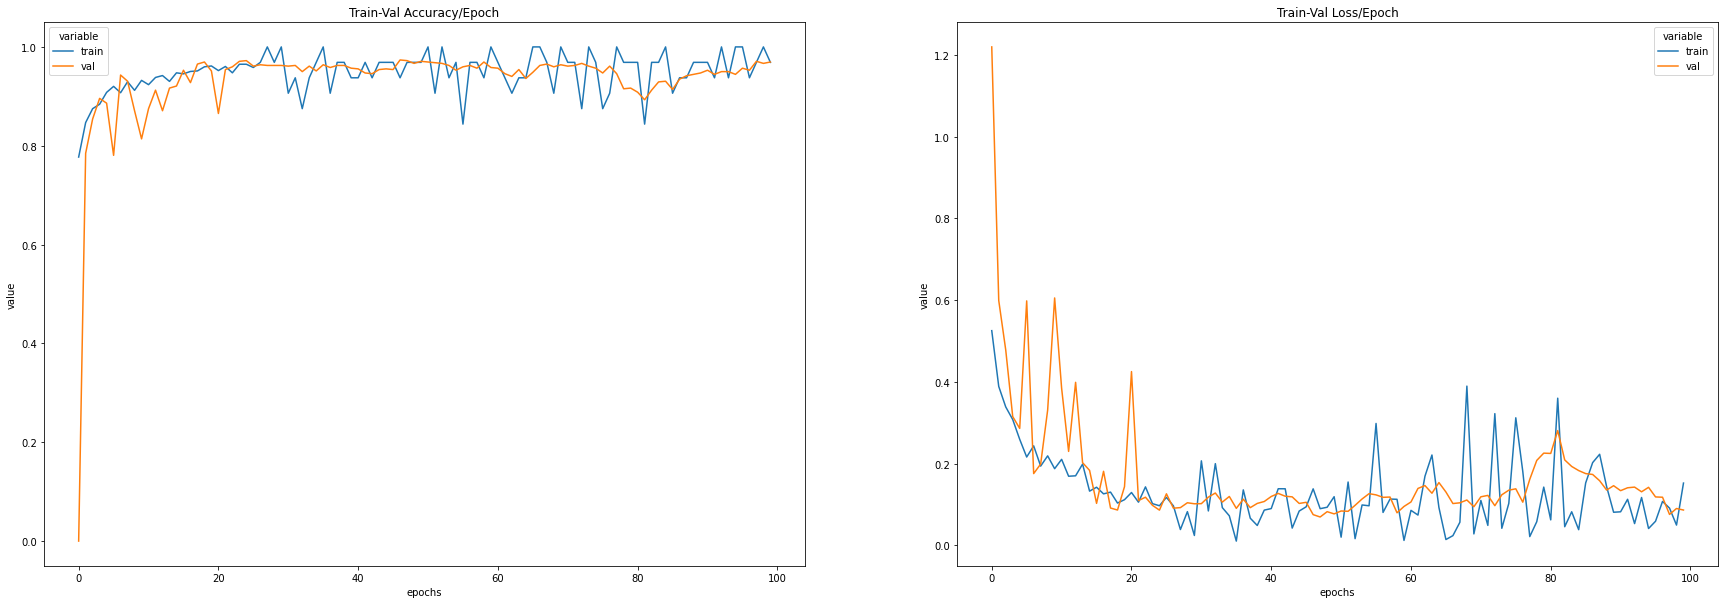

In [ ]:
plotter = kplt.PlotHelper()
plotter.show_training_results(acc_history, loss_history, logger=logger_patched_three)

### Test Phase

Displays the classification report based on the trained model.

              precision    recall  f1-score   support

       ACIDE       0.97      0.99      0.98       300
  WEDDELLITE       1.00      0.97      0.98       300
  WHEWELLITE       1.00      1.00      1.00       300

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900

--------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


1

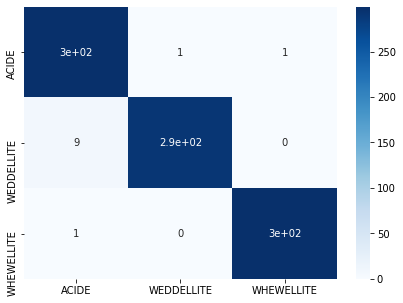

In [ ]:
trainer_patched_three.test(model=model_three, datamodule=dl_three_classes)

#Tensorboard Logs

Logs captured during the tests are stored in "tb_logs" and they can be analyzed using tensorboard.

In [ ]:
#uncomment this line to pull the latest logs from google drive.
#copy_logs("/content/drive/My Drive/Proyecto_CalculosRenales/ML/logs/")
synch_logs("/content/drive/My Drive/Proyecto_CalculosRenales/ML/logs/resnet34/")

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir "$LOGS_PATH/"